# **Covid-19 Detection Based on CXR Images With Deep Neural Network**

##**Import TensorFlow and other libraries**

In [1]:
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from google.colab import drive
from PIL import Image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Set up the input pipeline**

In this section, first, we download the dataset from Kaggle, and secondly create a directory for each class to save corresponded images. We then prepare the dataset so that we will feed a balanced dataset to train the model. After that, we select 80% of the data for training and 20% for testing. Before creating the model, some preprocessing functions are defined, and finally using tf.data.Dataset API we create a source dataset from the input data and then apply those functions to it to preprocess the data.



###**Load the dataset**

**Downloading dataset from kaggle:** 

In [3]:
!cp /content/gdrive/My\ Drive/covid/kaggle.json kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 97% 754M/778M [00:02<00:00, 318MB/s]
100% 778M/778M [00:02<00:00, 301MB/s]


In [4]:
!unzip -q covid19-radiography-database.zip -d covid

In [5]:
covid_path = '/content/covid/COVID-19_Radiography_Dataset/COVID/images/*'
normal_path = '/content/covid/COVID-19_Radiography_Dataset/Normal/images/*'
covid_files = glob.glob(covid_path)
normal_files = glob.glob(normal_path)

###**Splitting dataset into training and test set**

To avoid feeding an imbalance dataset to the neural network, we pick an equal number of examples from both the "normal" and "covid" classes. Using an imbalance dataset to train the model cause the model to assume that any data we feed, belongs to the majority class.
We then select 80% of the data for training and 20% for testing.

In [6]:
m = min(len(covid_files), len(normal_files))
#m = 1500
N = int(0.8*m)
random.shuffle(covid_files)
random.shuffle(normal_files)
covid_train, covid_test = (covid_files[:m])[:N], (covid_files[:m])[N:]
normal_train, normal_test = (normal_files[:m])[:N], (normal_files[:m])[N:]
train_images = covid_train + normal_train
test_images = covid_test + normal_test
random.shuffle(train_images)
random.shuffle(test_images)

**Setting some hyperparameters:**

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 50
IMG_WIDTH = 224
IMG_HEIGHT = 224

###**Defining some functions for reading data and preprocessing.**

We apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting. In random jittering, the image is resized to 224 x 224 and then randomly cropped to 224 x 224. In random mirroring, the image is randomly flipped horizontally. We only resize the test images to 244x244. Then by using "preprocess_input", the images are converted from RGB to BGR, and then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. 

In [9]:
def load(image_file):
  ##reading images
  image = tf.io.read_file(image_file)
  #returns a tensor of type uint8 and with channels = 3 outputs an RGB image.
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.cast(image, tf.float32)
  #label assigning
  class1 = tf.constant([".+images/COVID.+"])
  class0 = tf.constant([".+images/Normal.+"])
  if tf.strings.regex_full_match(image_file,class0[0]):
    label = tf.constant(0,dtype=tf.float32)
  else:
    label = tf.constant(1,dtype=tf.float32)
  return image,label

def resize(image, label, height, width):
  image = tf.image.resize(image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image, label

def random_crop(image, label):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image, label

@tf.function()
def random_jitter(image, label):
  # resizing to 274 x 274 x 3
  image, label = resize(image, label, 274, 274)
  # randomly cropping to 224 x 224 x 3
  image, label = random_crop(image, label)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image, label

def preprocess_image_train(image_file):
  image, label = load(image_file)
  image, label = random_jitter(image, label)
  image = preprocess_input(image)
  return image, label

def preprocess_image_test(image_file):
  image, label = load(image_file)
  image, label = resize(image, label, IMG_WIDTH, IMG_HEIGHT)
  image = preprocess_input(image)
  return image, label

###**Input pipeline**

**Creating dataset and applying preprocessing steps:**

The tf.data.Dataset API supports writing descriptive and efficient input pipelines.To do so, we first create a source dataset from the input data.
and then apply dataset transformations to preprocess the data.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = train_ds.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    600).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

##**Create the model**

In [11]:
base = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base.output
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

for layer in base.layers:
  layer.trainable = False

model = Model(inputs=base.input, outputs=x)
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

##**Compile the model**

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='bce', metrics=['acc'])
epochs=30
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=epochs, shuffle=True, validation_data=test_ds)


Epoch 1/30
116/116 [==============================] - 85s 542ms/step - loss: 2.4573 - acc: 0.4322 - val_loss: 1.9267 - val_acc: 0.5200
Epoch 2/30
116/116 [==============================] - 51s 441ms/step - loss: 1.7202 - acc: 0.4879 - val_loss: 1.4972 - val_acc: 0.5656
Epoch 3/30
116/116 [==============================] - 51s 438ms/step - loss: 1.3908 - acc: 0.5386 - val_loss: 1.2656 - val_acc: 0.6070
Epoch 4/30
116/116 [==============================] - 52s 447ms/step - loss: 1.1655 - acc: 0.5852 - val_loss: 1.0986 - val_acc: 0.6374
Epoch 5/30
116/116 [==============================] - 51s 444ms/step - loss: 1.0076 - acc: 0.6181 - val_loss: 0.9760 - val_acc: 0.6588
Epoch 6/30
116/116 [==============================] - 52s 445ms/step - loss: 0.8957 - acc: 0.6466 - val_loss: 0.8895 - val_acc: 0.6809
Epoch 7/30
116/116 [==============================] - 52s 445ms/step - loss: 0.8120 - acc: 0.6698 - val_loss: 0.8186 - val_acc: 0.6920
Epoch 8/30
116/116 [==============================] - 5

##**Visualize training results**

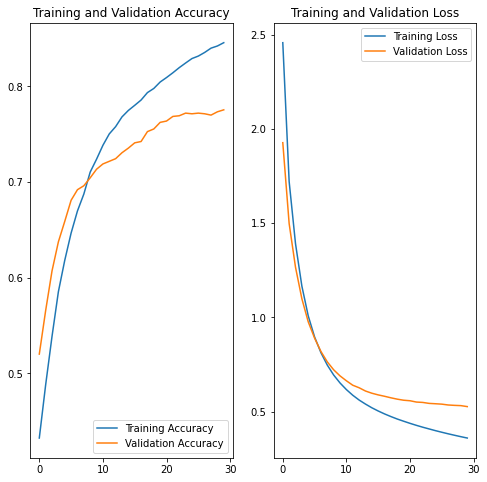

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##**Predictions of network**

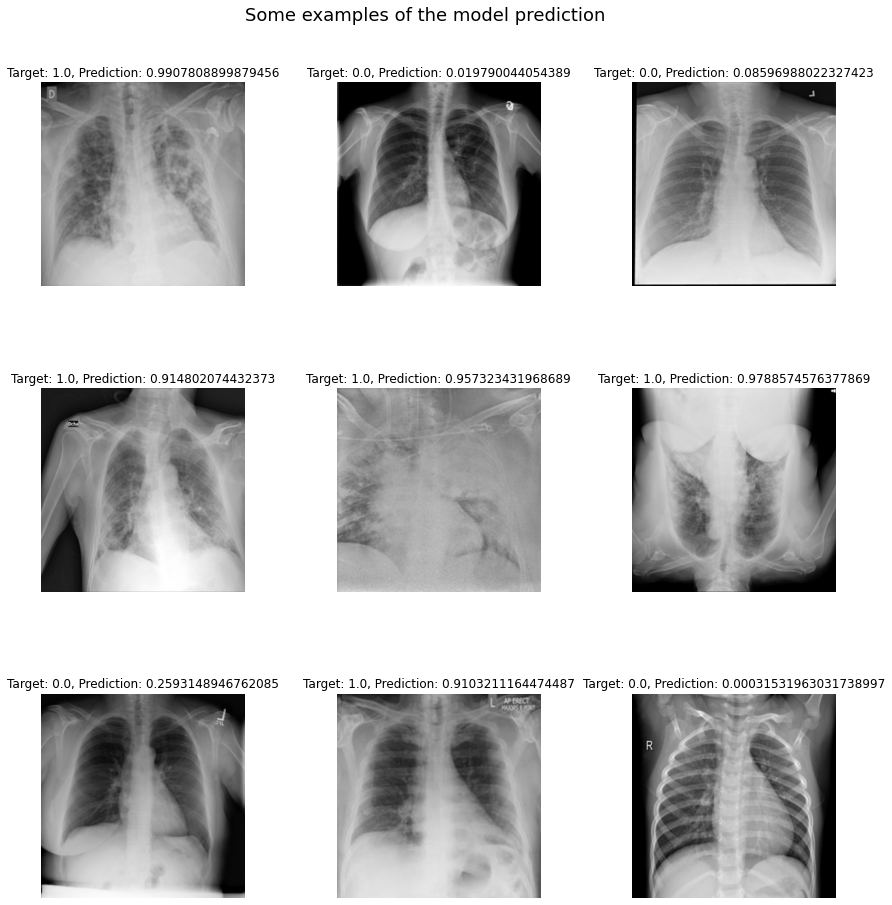

In [15]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Some examples of the model prediction", fontsize=18, y=0.95)

for n, dir in enumerate(random.sample(test_images,300)[2:11]):

  image, label = preprocess_image_test(dir)
  ax = plt.subplot(3, 3, n + 1)
  prediction = model.predict(image[tf.newaxis,...])
  ax.title.set_text(f'Target: {label}, Prediction: {prediction[0][0]}')
  plt.imshow(cv2.imread(dir))
  plt.axis('off')